# Phase 4 Project

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder, OrdinalEncoder

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, plot_confusion_matrix

In [2]:
df = pd.read_csv('/Users/meaghanross/Documents/Flatiron/Phase4/NLP_project/data/tweet_product_company.csv', encoding='latin1' )

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.shape

(9093, 3)

In [5]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [6]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

To do

2) Fill nas for the brand
3) Label encode the target 
6) dropping 'I can't tell'
7) drop duplicates


In [7]:
df['target']=df['is_there_an_emotion_directed_at_a_brand_or_product']

In [8]:
df.drop('is_there_an_emotion_directed_at_a_brand_or_product',axis=1, inplace=True)

In [9]:
df['text']=df['tweet_text']

In [10]:
df.drop('tweet_text',axis=1, inplace=True)

In [11]:
df.shape

(9093, 3)

__Drop Duplicates__

In [12]:
df.duplicated().sum()

22

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.shape

(9071, 3)

In [15]:
df.dropna(subset=['text'], inplace=True)

In [16]:
df.target.value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: target, dtype: int64

In [17]:
df.text.isna().sum()

0

__Train-Test Split__

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['target'], 
                                                    random_state=42,
                                                    stratify=df['target'])

In [19]:
X_train.shape

(6802,)

__Data Cleaning__

For cleaning we want to drop 'I can't tell' after merging `X_train` with `y_train` and `X_test` with `y_test` to and Label Encode the target to numerical data.

In [20]:
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

In [21]:
y_train.value_counts()

No emotion toward brand or product    4031
Positive emotion                      2227
Negative emotion                       427
I can't tell                           117
Name: target, dtype: int64

In [22]:
df_train.head()

,text,target
2769,I want one!! It's not a rumor: Apple is openin...,Positive emotion
2787,#AAPL already the big winner at #sxsw {link} #in,No emotion toward brand or product
7021,@mention Only Google's disavowal of its planne...,No emotion toward brand or product
4882,Anyone who was going to buy a new iPad should ...,I can't tell
715,So {link} is part of my presentation at #SXSW ...,Positive emotion


In [23]:
def drop_unidentified(df):
    '''
    Drop rows from DataFrame where the target is 'I can't tell'.
    '''
    df.drop(df.loc[df['target']=="I can't tell"].index, inplace=True)
    return df

In [24]:
def label(df):
    '''
    Encode values of the target to numerical data.
    '''
    df['target'] = df['target'].map({'No emotion toward brand or product': 0,
                                     'Negative emotion': 1,
                                     'Positive emotion': 2})
    return df

In [25]:
cleaning_pipeline = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_unidentified)),
    ('label', FunctionTransformer(label))
])

In [26]:
df_train_clean = cleaning_pipeline.fit_transform(df_train)
df_test_clean = cleaning_pipeline.transform(df_test)

In [27]:
df_test_clean.head()

,text,target
5039,RT @mention : Aron Pilhofer from The New York ...,0
643,"Ok nerds, I totally am Bateman. You want me to...",0
4451,Podcast on Social Business Summit 2011 AUSTIN ...,2
177,This is a #WINNING picture #android #google #s...,2
4980,Team Android at SXSW ÛÒ full party details re...,2


## Model Iterations

In [28]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Macro Precision:', results['train_precision_macro'].mean())
    print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
    print('##############')
    print('Training Macro Recall:', results['train_recall_macro'].mean())
    print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
    print('##############')
    print('Training Macro F1:', results['train_f1_macro'].mean())
    print('Cross_Val Macro F1:', results['test_f1_macro'].mean())


### FSM

In [29]:
sw = stopwords.words('english')

In [30]:
fsm_pipe = Pipeline([('cv', CountVectorizer(stop_words=sw)),
                     ('mnb', MultinomialNB())
])

In [34]:
fsm_pipe.fit(df_train_clean['text'], df_train_clean['target'])

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mnb', MultinomialNB())])

In [32]:
print_cv_scores(fsm_pipe, df_train_clean['text'], df_train_clean['target'])

[0.83246073 0.82834705 0.83807031 0.83451758 0.83769634]
Training Accuracy 0.8342183994016455
##############
[0.66791324 0.65295438 0.69334331 0.68511593 0.64697083]
Cross_Val Accuracy 0.6692595362752431
##############
Training Macro Precision: 0.8434175210453303
Cross_Val Macro Precision: 0.6528123538208142
##############
Training Macro Recall: 0.7076100950650448
Cross_Val Macro Recall: 0.4842001160528876
##############
Training Macro F1: 0.7511779766750047
Cross_Val Macro F1: 0.5029316530646247


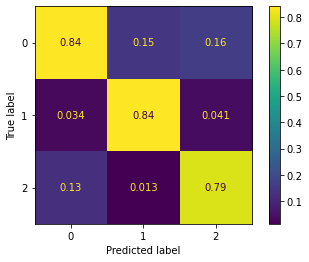

In [35]:
plot_confusion_matrix(fsm_pipe, 
                      df_train_clean['text'], 
                      df_train_clean['target'], 
                      normalize='pred');

In [40]:
bayes_pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw)),
                       ('mnb', MultinomialNB())
])

In [41]:
bayes_pipe.fit(df_train_clean['text'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mnb', MultinomialNB())])

In [42]:
print_cv_scores(bayes_pipe, df_train_clean['text'], df_train_clean['target'])

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

[0.7578534  0.75317876 0.74831713 0.74850411 0.76271503]
Training Accuracy 0.7541136873597607
##############
[0.64547494 0.65295438 0.66342558 0.66043381 0.64697083]
Cross_Val Accuracy 0.6538519072550486
##############
Training Macro Precision: 0.8785256264483937
Cross_Val Macro Precision: 0.45402555592046906
##############
Training Macro Recall: 0.49072138146803973
Cross_Val Macro Recall: 0.3958110807053479
##############
Training Macro F1: 0.4931023607640201
Cross_Val Macro F1: 0.3733941200907602


/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


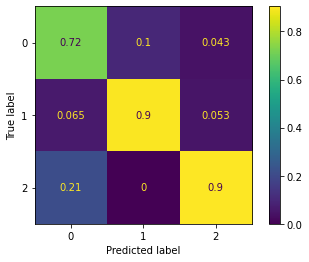

In [43]:
plot_confusion_matrix(bayes_pipe, 
                      df_train_clean['text'], 
                      df_train_clean['target'], 
                      normalize='pred');

In [61]:
bayes_pipe[0].vocabulary_

{'want': 7990,
 'one': 5149,
 'rumor': 6267,
 'apple': 584,
 'opening': 5173,
 'temporary': 7345,
 'store': 7001,
 'downtown': 2301,
 'austin': 724,
 'sxsw': 7171,
 'ipad': 3938,
 'launch': 4225,
 'link': 4346,
 'aapl': 282,
 'already': 474,
 'big': 956,
 'winner': 8116,
 'mention': 4666,
 'google': 3243,
 'disavowal': 2174,
 'planned': 5507,
 'part': 5312,
 'presentation': 5679,
 'good': 3236,
 'thing': 7414,
 'crashing': 1845,
 'instead': 3869,
 'works': 8173,
 'best': 940,
 'iphone': 3947,
 'android': 521,
 'ipad2': 3940,
 'sold': 6788,
 '70': 230,
 'went': 8061,
 'new': 4981,
 'buyers': 1229,
 'wow': 8191,
 'via': 7887,
 'yesterday': 8256,
 'listened': 4358,
 'marissa': 4559,
 'mayer': 4612,
 'discuss': 2188,
 'mobile': 4780,
 'technologies': 7323,
 '40': 164,
 'users': 7819,
 'use': 7814,
 'maps': 4547,
 'phones': 5435,
 'nothing': 5057,
 'quite': 5872,
 'like': 4329,
 'make': 4516,
 'desperately': 2091,
 'almost': 467,
 'drooling': 2329,
 'guy': 3366,
 'next': 4998,
 'everyone': 

In [47]:
bayes_smote_pipe = imbpipe([
                            ('tfidf', TfidfVectorizer(stop_words=sw)),
                            ('smote', SMOTE(random_state=42)),
                            ('mnb', MultinomialNB())
])

In [48]:
bayes_smote_pipe.fit(df_train_clean['text'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('smote', SMOTE(random_state=42)), ('mnb', MultinomialNB())])

In [49]:
print_cv_scores(bayes_smote_pipe, df_train_clean['text'], df_train_clean['target'])

[0.80179506 0.79693343 0.79805535 0.79356769 0.79618549]
Training Accuracy 0.7973074046372476
##############
[0.59685864 0.57741212 0.61032162 0.62378459 0.55946148]
Cross_Val Accuracy 0.593567688855647
##############
Training Macro Precision: 0.721952478755176
Cross_Val Macro Precision: 0.5140018000336204
##############
Training Macro Recall: 0.8588563291546129
Cross_Val Macro Recall: 0.5859285060891916
##############
Training Macro F1: 0.7610232125599717
Cross_Val Macro F1: 0.5265757925196674


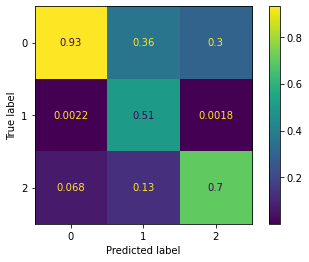

In [50]:
plot_confusion_matrix(bayes_smote_pipe, 
                      df_train_clean['text'], 
                      df_train_clean['target'], 
                      normalize='pred');

In [55]:
xgb_pipe = imbpipe(steps=[('tfidf', TfidfVectorizer(stop_words=sw)),
                          ('sm', SMOTE(random_state=42)),
                          ('xgb', XGBClassifier(random_state=42,
                                                max_depth = 6,
                                                n_jobs = -1))])

In [56]:
xgb_pipe.fit(df_train_clean['text'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('sm', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=0.5,...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth

In [57]:
print_cv_scores(xgb_pipe, df_train_clean['text'], df_train_clean['target'])

[0.85115931 0.8513463  0.84891548 0.84928945 0.85471204]
Training Accuracy 0.8510845175766641
##############
[0.6671653  0.65893792 0.68586387 0.68436799 0.64921466]
Cross_Val Accuracy 0.6691099476439791
##############
Training Macro Precision: 0.8931912847303318
Cross_Val Macro Precision: 0.5965455902951406
##############
Training Macro Recall: 0.7507644307506374
Cross_Val Macro Recall: 0.49571689304786837
##############
Training Macro F1: 0.801671410036974
Cross_Val Macro F1: 0.5195228879591818


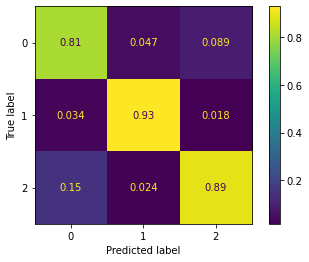

In [58]:
plot_confusion_matrix(xgb_pipe, 
                      df_train_clean['text'], 
                      df_train_clean['target'], 
                      normalize='pred');

In [104]:
xgb_gs_pipe = imbpipe(steps=[('tfidf', TfidfVectorizer(stop_words=sw, 
                                                       token_pattern=r'(?u)\b[A-Za-z]+\b')),
                              ('sm', SMOTE(random_state=42)),
                              ('xgb', XGBClassifier(random_state=42,
                                                   n_jobs = -1,
                                                   max_depth=6,
                                                   tree_method= 'hist'))])

In [105]:
param_grid = [{'tfidf__max_features': [5000, None],
               'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]}]

In [106]:
gs_pipe = GridSearchCV(estimator=xgb_gs_pipe, param_grid=param_grid, verbose=2, scoring='precision_macro')

In [107]:
gs_pipe.fit(df_train_clean['text'], df_train_clean['target'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  10.4s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  10.3s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  10.3s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  10.2s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  10.3s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=  14.2s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=  14.4s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=  14.2s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=  14.1s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=  13.8s
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(2, 2); total time=   5.0s
[CV] END tfidf__max_features=5000, tfidf__ngram_r

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                    

In [109]:
pd.DataFrame(gs_pipe.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf__max_features,param_tfidf__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.256396,0.079050,0.029903,0.000230,5000,"(1, 1)","{'tfidf__max_features': 5000, 'tfidf__ngram_ra...",0.607171,0.570861,0.591048,0.614592,0.529008,0.582536,0.030687,3
1,14.087179,0.176503,0.040029,0.000235,5000,"(1, 2)","{'tfidf__max_features': 5000, 'tfidf__ngram_ra...",0.535832,0.584601,0.573057,0.623085,0.531591,0.569633,0.033712,4
2,4.915064,0.047946,0.030069,0.000142,5000,"(2, 2)","{'tfidf__max_features': 5000, 'tfidf__ngram_ra...",0.471193,0.494502,0.468016,0.491837,0.465145,0.478139,0.012449,6
3,11.468010,0.155647,0.029715,0.000118,None,"(1, 1)","{'tfidf__max_features': None, 'tfidf__ngram_ra...",0.625864,0.580207,0.586743,0.642704,0.561428,0.599389,0.030153,2
4,31.692422,0.462318,0.048071,0.000916,None,"(1, 2)","{'tfidf__max_features': None, 'tfidf__ngram_ra...",0.640050,0.597764,0.609489,0.692304,0.556106,0.619143,0.045417,1
5,16.301852,0.323872,0.036296,0.000367,None,"(2, 2)","{'tfidf__max_features': None, 'tfidf__ngram_ra...",0.596491,0.570866,0.552581,0.618080,0.506935,0.568991,0.038183,5


In [110]:
gs_pipe.best_score_

0.6191427132695128

In [111]:
idf_values = dict(zip(gs_pipe.best_estimator_[0].get_feature_names(), gs_pipe.best_estimator_[0].idf_))
idf_values

{'aapl': 7.610546489643824,
 'aapl already': 9.114623886420098,
 'aapl knows': 9.114623886420098,
 'aapl link': 9.114623886420098,
 'aapl open': 9.114623886420098,
 'aapl put': 9.114623886420098,
 'aaron': 9.114623886420098,
 'aaron forth': 9.114623886420098,
 'aarpbulletin': 8.709158778311934,
 'aarpbulletin mobile': 8.709158778311934,
 'ab': 8.709158778311934,
 'ab google': 9.114623886420098,
 'ab ipad': 9.114623886420098,
 'abandoned': 9.114623886420098,
 'abandoned reality': 9.114623886420098,
 'aber': 9.114623886420098,
 'aber leider': 9.114623886420098,
 'ability': 8.709158778311934,
 'ability see': 9.114623886420098,
 'ability sell': 9.114623886420098,
 'able': 6.373783862494898,
 'able afford': 7.5051859739859985,
 'able attend': 8.016011597751989,
 'able buy': 9.114623886420098,
 'able check': 9.114623886420098,
 'able communicate': 8.709158778311934,
 'able download': 9.114623886420098,
 'able find': 9.114623886420098,
 'able get': 8.016011597751989,
 'able grab': 9.114623886

In [112]:
max(gs_pipe.best_estimator_[0].idf_)

9.114623886420098

## EDA

In [113]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(df['text'].values.astype('U'))
total_df = pd.DataFrame(text_counts.todense(),columns = cv.get_feature_names())

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


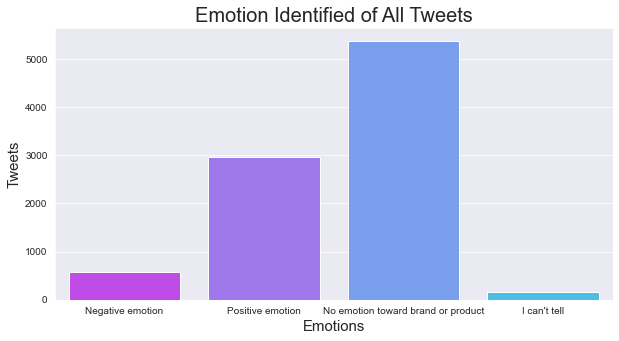

In [114]:
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
all_count_viz = sns.countplot(df['target'], palette='cool_r')
all_count_viz.set_title('Emotion Identified of All Tweets',fontsize = 20)
all_count_viz.set_xlabel('Emotions',fontsize = 15)
all_count_viz.set_ylabel('Tweets',fontsize = 15)
plt.show()

/Users/meaghanross/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


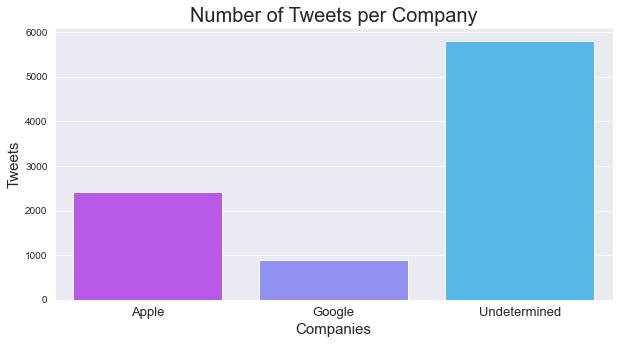

In [48]:
apple_products = ('iPhone', 'iPad or iPhone App', 'iPad','Apple','Other Apple product or service')
google_products = ('Google','Android','Android App','Other Google product or service')
def brand(x):
    if x in apple_products:
        return 'Apple'
    if x in google_products:
        return 'Google'
    else:
        return 'Neither'
df['brand'] = df['emotion_in_tweet_is_directed_at'].apply(brand)

# Plot resulting counts of tweet targets
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
brand_viz = sns.countplot(df['brand'], palette = 'cool_r')
brand_viz.set_title('Number of Tweets per Company',fontsize = 20)
brand_viz.set_xlabel('Companies',fontsize = 15)
brand_viz.set_ylabel('Tweets',fontsize = 15)
brand_viz.set_xticklabels(['Apple','Google', 'Undetermined'],fontsize = 13)
plt.show()

## Metrics